# Lead Free Buffalo ML Model

## Data Preprocessing: Flint Data

This notebook records the procedure I used to preprocess the Flint data for my project [Lead Free Buffalo](https://leadfreebflo.com).

This notebook has a slightly different scope than the Buffalo data preprocessing notebook. Since I used the Zillow API to assemble the, 

I will only be doing a small amount of preprocessing in this notebook, much of the data preparation has been done prior to this and I won't repeat it all. 

1. Load in the CSV files `joined_lead_hud.csv`, which contains results from the lead testing campaign and data from HUD on housing values, and `z_data_flint`, which contains the Zillow data I have . I needed to use this because the HUD data does not contain a home age feature, and that is a very important 
2. Merge the two resulting dataframes on addresses
3. Do some inspection of the data to validate the processing work.
4. Visualize the data.
5. Begin learning on the data and see what the results are like.

We begin with some imports and loading in the data:

In [1]:
import pandas as pd

%matplotlib inline

lead_hud_data_flint = pd.read_csv('data-flint/joined_lead_hud.csv', encoding='unicode_escape', index_col = 0)
zillow_data_flint = pd.read_csv('data-flint/z_data_flint.csv', encoding='unicode_escape', index_col = 0)

#print(lead_hud_data_flint.count(), zillow_data_flint.count())

zillow_data_flint.loc[4970]
lead_hud_data_flint.iloc[4970]

Sample Number                         LG46219
Date Submitted            2016-05-19 12:36:44
Analysis (Lead)                          Lead
Lead (ppb)                                  4
Analysis (Copper)                      Copper
Copper (ppb)                              220
Prop_Num_str                             5605
PropStreet                          DUPONT ST
City                                    FLINT
Prop_Zip_x                              48505
CCond2013                                    
CenBlock                                    3
CenTract                                  300
Class                                      RI
DPVACT                                      N
DPVNOST                                     N
DRAFT_Zone                               TN-2
ECF                                       170
HCond2012                                Good
HCond2014                                Good
Homestead                                 100
Land_Usex                         

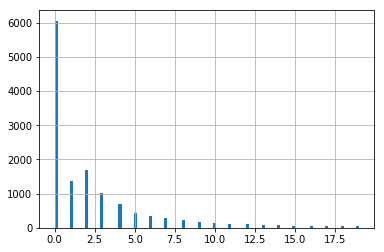

In [2]:
#lead_hud_data_flint['Prop_Num_str'] = joined_lead_hud_data['Prop_Num_str'].astype(str)
#zillow_data_flint['street_upper'] = joined

#house_lead_flint_mergeddata = 

lead_hist = lead_hud_data_flint.loc[lead_hud_data_flint['Lead (ppb)'] < 20]['Lead (ppb)'].hist(bins = 100)

## Census tool

Using the census tool again. Fortunately we only have ~15,000 rows, so we should be able to do this in a 

house number and street name in one field, city in the next, then state, then 5-digit zip code. The

In [3]:
import numpy as np

leadhud_flint_census = lead_hud_data_flint[['TaxPAddres', 'TaxPCity', 'TaxPState', 'TaxPZip']]

leadhud_flint_census_1, leadhud_flint_census_2 = np.array_split(leadhud_flint_census, 2)

In [4]:
zillow_data_flint['zipcode'] = zillow_data_flint['zipcode'].astype(str)

zdata_flint_census = zillow_data_flint[['street', 'city', 'state', 'zipcode']]

zdata_flint_census_1, zdata_flint_census_2 = np.array_split(zdata_flint_census, 2)


for idx, files in enumerate([leadhud_flint_census_1, leadhud_flint_census_2, zdata_flint_census_1, zdata_flint_census_2]):
    with open('data-flint/flint_census_{}.csv'.format(idx), 'w+') as f:
        files.to_csv(f)


Now we upload for processing and then download again

In [5]:
names = ['id', 'addr', 'match', 'type', 'addr_2', 'latlon', 'code', 'code2']

z_flint_census_1 = pd.read_csv('data-flint/GeocodeResults_2.csv', names=names)
z_flint_census_2 = pd.read_csv('data-flint/GeocodeResults_3.csv', names=names)
lead_flint_census_1 = pd.read_csv('data-flint/GeocodeResults_0.csv', names=names)
lead_flint_census_2 = pd.read_csv('data-flint/GeocodeResults_1.csv', names=names)

In [6]:
z_flint_census_1.head()

,id,addr,match,type,addr_2,latlon,code,code2
0,17285,", , , nan",No_Match,NaN,NaN,NaN,NaN,NaN
1,4970,"1608 Cromwell Ave, Flint, MI, 48503.0",Match,Exact,"1608 CROMWELL AVE, FLINT, MI, 48503","-83.66882,43.02084",647468711.0,R
2,17286,", , , nan",No_Match,NaN,NaN,NaN,NaN,NaN
3,17280,"5062 Rossway Dr, Flint, MI, 48506.0",Match,Exact,"5062 ROSSWAY DR, FLINT, MI, 48506","-83.61393,43.07272",69570043.0,R
4,17281,"5092 Rossway Dr, Flint, MI, 48506.0",Match,Exact,"5092 ROSSWAY DR, FLINT, MI, 48506","-83.613525,43.072723",69570043.0,R


In [7]:
z_flint_census = pd.concat([z_flint_census_1, z_flint_census_2])
lead_flint_census = pd.concat([lead_flint_census_1, lead_flint_census_2])

z_flint_census.dropna(inplace=True, subset=['id'])
lead_flint_census.dropna(inplace=True, subset=['id'])

#Cast to integer and ignore errors 

z_flint_census['id'] = pd.to_numeric(z_flint_census['id'], errors='coerce')
z_flint_census.dropna(inplace=True, subset=['id'])
z_flint_census['id'] = z_flint_census['id'].astype('int')

lead_flint_census['id'] = pd.to_numeric(lead_flint_census['id'], errors='coerce')
lead_flint_census.dropna(inplace=True, subset=['id'])
lead_flint_census['id'] = lead_flint_census['id'].astype('int')


Here we're joining `z_flint_census` into `zillow_data_flint` and `lead_flint_census` into `lead_hud_data_flint`. Fortunately this is pretty easy since the ID is preserved

In [8]:
zillow_data_flint = zillow_data_flint.join(z_flint_census)
lead_hud_data_flint = lead_hud_data_flint.join(lead_flint_census)

In [14]:
lead_flint_census.count()

id        14114
addr      14114
match     14114
type      13063
addr_2    13063
latlon    13063
code      13063
code2     13063
dtype: int64

In [16]:
z_flint_census.count()

id        15491
addr      15491
match     15491
type      11841
addr_2    11841
latlon    11841
code      11841
code2     11841
dtype: int64

Now we need to figure out how to join between the two - what field should we be merging on? 
Putting the addresses through the census tool has given us a shared address field. Can't remember which one that is, so I'll try both and check which one gets the kind of matching we're looking for (use `df.counts()` to see how many non-null records we get)

In [10]:
#lead_hud_data_flint.join(zillow_data_flint, on=['addr_2']).counts()
zillow_data_flint['addr_2']

2                                          NaN
2             1701 RUSSET PL, FLINT, MI, 48504
3            5062 ROSSWAY DR, FLINT, MI, 48506
3             1711 RUSSET PL, FLINT, MI, 48504
4            5092 ROSSWAY DR, FLINT, MI, 48506
4             1815 RUSSET PL, FLINT, MI, 48504
5            5109 ROSSWAY DR, FLINT, MI, 48506
5            6701 RUSSETT CT, FLINT, MI, 48504
6        1071 ROYAL CREST DR, FLINT, MI, 48532
6           1706 ROSELAWN DR, FLINT, MI, 48504
7         2732 BROWNELL BLVD, FLINT, MI, 48504
7           1713 ROSELAWN DR, FLINT, MI, 48504
8         2714 BROWNELL BLVD, FLINT, MI, 48504
8        2714 N STEVENSON ST, FLINT, MI, 48504
10        2702 BROWNELL BLVD, FLINT, MI, 48504
10          1717 ROSELAWN DR, FLINT, MI, 48504
11        2702 BROWNELL BLVD, FLINT, MI, 48504
11          6801 ROSEANNA DR, FLINT, MI, 48505
12        2644 BROWNELL BLVD, FLINT, MI, 48504
12         2201 STEVENSON ST, FLINT, MI, 48504
13         3422 CLAIRMONT ST, FLINT, MI, 48503
13           

In [11]:
zillow_data_flint.head()

,street,zipcode,city,state,latitude,longitude,useCode,taxAssessmentYear,taxAssessment,yearBuilt,Accessed,Address,id,addr,match,type,addr_2,latlon,code,code2
2,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,"308 4TH AVE, FLINT, MI, 48503",17286.0,", , , nan",No_Match,NaN,NaN,NaN,NaN,NaN
2,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,"308 4TH AVE, FLINT, MI, 48503",17292.0,"1701 Russett Pl, Flint, MI, 48504.0",Match,Non_Exact,"1701 RUSSET PL, FLINT, MI, 48504","-83.72457,43.072163",69563642.0,L
3,2417 Adair St,48506.0,Flint,MI,43.038107,-83.660348,SingleFamily,2012.0,17200.0,1958.0,True,"2417 ADAIR ST, FLINT, MI, 48506",17280.0,"5062 Rossway Dr, Flint, MI, 48506.0",Match,Exact,"5062 ROSSWAY DR, FLINT, MI, 48506","-83.61393,43.07272",69570043.0,R
3,2417 Adair St,48506.0,Flint,MI,43.038107,-83.660348,SingleFamily,2012.0,17200.0,1958.0,True,"2417 ADAIR ST, FLINT, MI, 48506",17293.0,"1711 Russett Pl, Flint, MI, 48504.0",Match,Non_Exact,"1711 RUSSET PL, FLINT, MI, 48504","-83.72465,43.07216",69563642.0,L
4,2421 Adair St,48506.0,Flint,MI,43.038217,-83.660341,SingleFamily,2012.0,12200.0,1921.0,True,"2421 ADAIR ST, FLINT, MI, 48506",17281.0,"5092 Rossway Dr, Flint, MI, 48506.0",Match,Exact,"5092 ROSSWAY DR, FLINT, MI, 48506","-83.613525,43.072723",69570043.0,R
